# Setup

In [ ]:
!nvidia-smi

!pip install -q -U watermark 
!pip install -qq transformers
!pip install transformers==3

%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Wed Mar 17 23:04:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Data Exploration

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving training_set_cln.csv to training_set_cln.csv


In [ ]:
import io
df_raw = pd.read_csv(io.BytesIO(uploaded['training_set_cln.csv']))
df_raw = df_raw[['rating', 'content']]

In [ ]:
df = df_raw[df_raw['rating'] != 3]

# Define Sentiment Classes

In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  else: 
    return 1

df['sentiment'] = df.rating.apply(to_sentiment)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


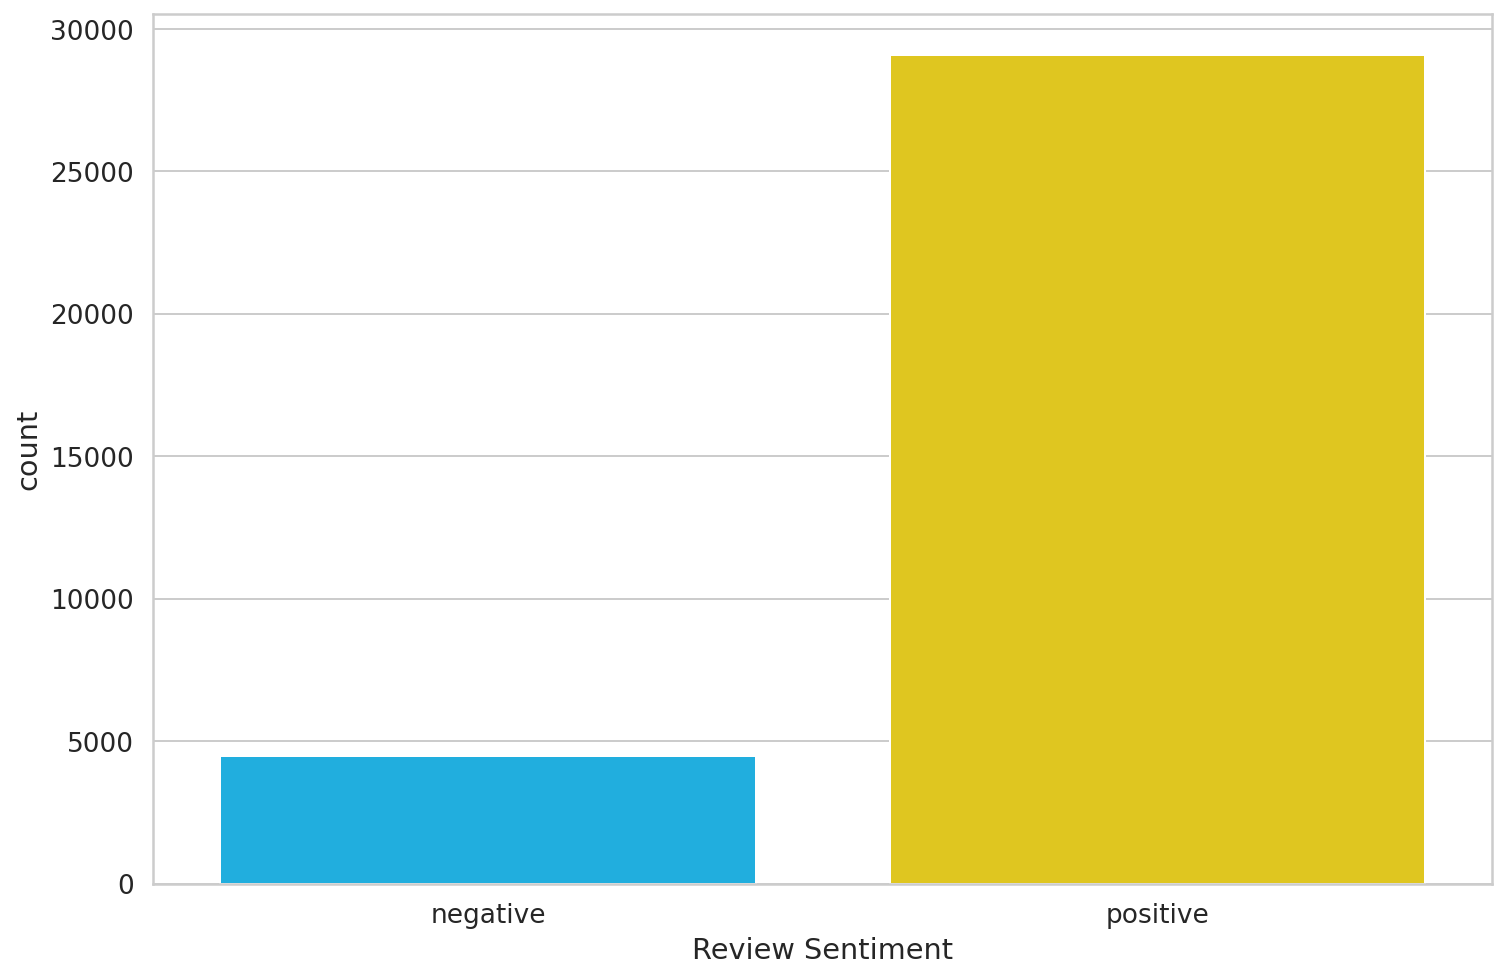

In [ ]:
class_names = ['negative', 'positive']

ax = sns.countplot(df.sentiment)
plt.xlabel('Review Sentiment')
ax.set_xticklabels(class_names);

# Data Preprocessing

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
sample_txt = 'Very adaptable to all different location mounts.'

encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

### Choosing Sequence Length

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


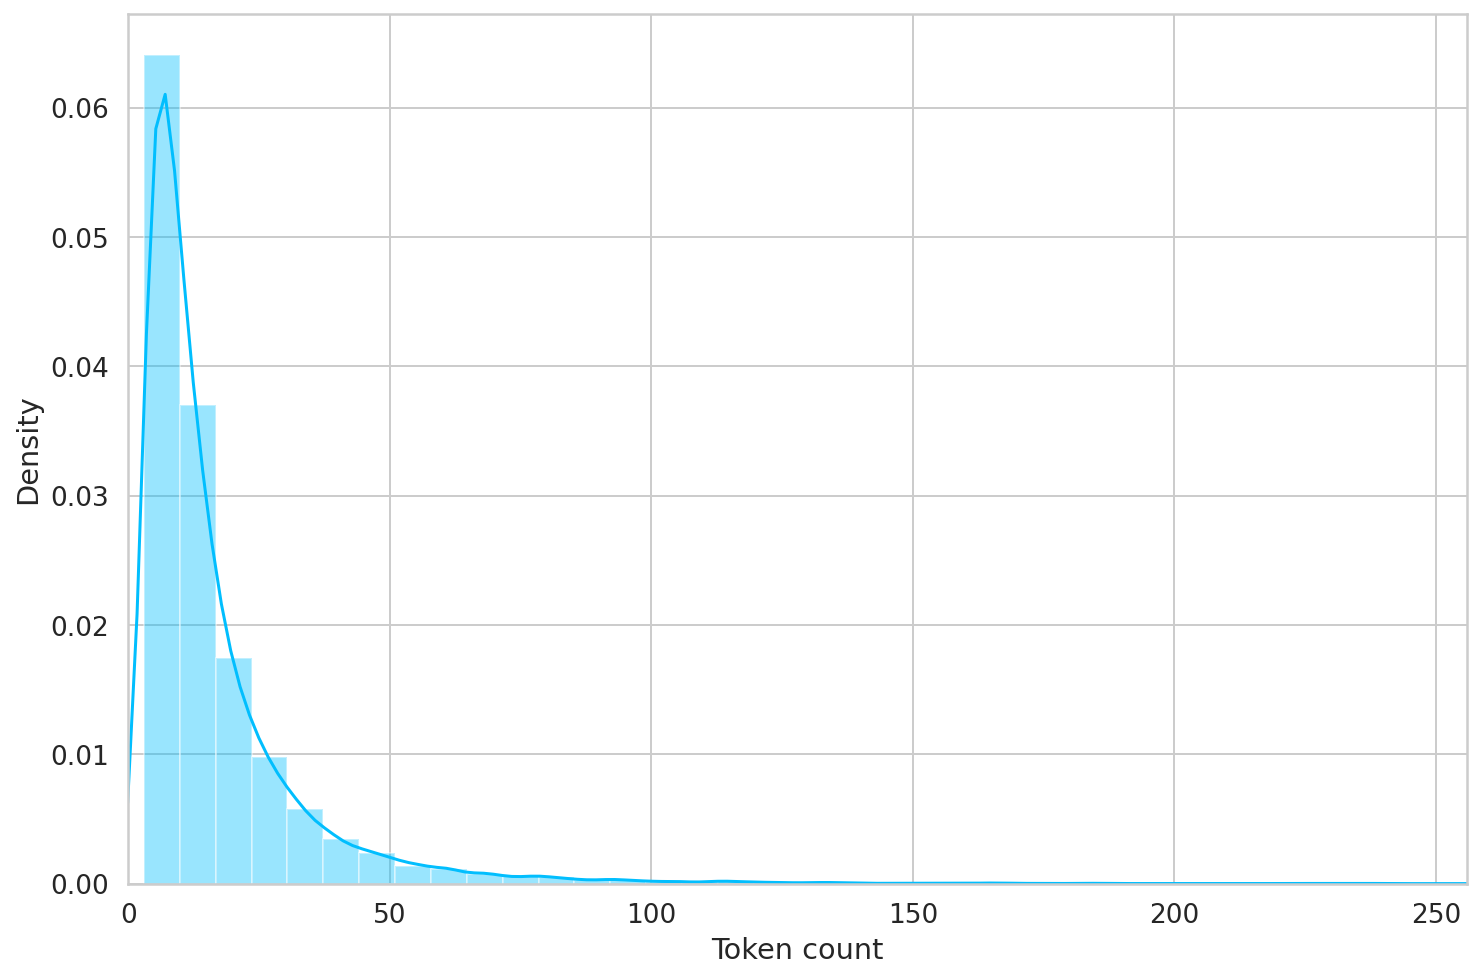

In [ ]:
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 150

### Create Training, Validation, and Testing Datasets

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):  
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train_raw, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train_raw.shape, df_val.shape, df_test.shape

((30205, 3), (1678, 3), (1679, 3))

### Create Balanced Training Set

In [ ]:
df_tr1 = df_train_raw[df_train_raw['rating'] <= 2]
df_tr2 = df_train_raw[df_train_raw['rating'] >= 4]

print(df_tr1.rating.count())
print(df_tr2.rating.count())

4003
26202


In [ ]:
df_tr1_os = df_tr1.sample(df_tr2.shape[0], replace=True)
df_tr2_os = df_tr2


print(df_tr1_os.rating.count())
print(df_tr2_os.rating.count())

df_train = pd.concat([df_tr1_os, df_tr2_os])

26202
26202


### Create Data Loader

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    shuffle=True,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader,))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 150])
torch.Size([16, 150])
torch.Size([16])


# Sentiment Classification with BERT

### BERT Setup

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
last_hidden_state, pooled_output = bert_model(input_ids=encoding['input_ids'], 
                                              attention_mask=encoding['attention_mask'])

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)

model(input_ids, attention_mask)

torch.Size([16, 150])
torch.Size([16, 150])


tensor([[-0.5676, -0.0608],
        [-0.2693, -0.0733],
        [-0.0761,  0.0010],
        [-0.1112,  0.2624],
        [-0.4874, -0.1455],
        [-0.1859, -0.0371],
        [-0.0629, -0.4174],
        [-0.1861, -0.0943],
        [-0.4568, -0.1186],
        [-0.3173, -0.3869],
        [-0.6276, -0.2110],
        [ 0.1798, -0.4233],
        [-0.1227,  0.0571],
        [-0.8575, -0.0167],
        [-0.9564, -0.5388],
        [-0.5125, -0.4553]], device='cuda:0', grad_fn=<AddmmBackward>)

### Model Environment

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

### Loading Model

In [ ]:
model.load_state_dict(torch.load('SA_Model_v7_2cls_os_shuffle.pt'))
model.to(device)

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

### Evaluation

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9618820726622991

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, 
                                                               test_data_loader)

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.87      0.88      0.87       248
    positive       0.98      0.98      0.98      1431

    accuracy                           0.96      1679
   macro avg       0.92      0.93      0.92      1679
weighted avg       0.96      0.96      0.96      1679



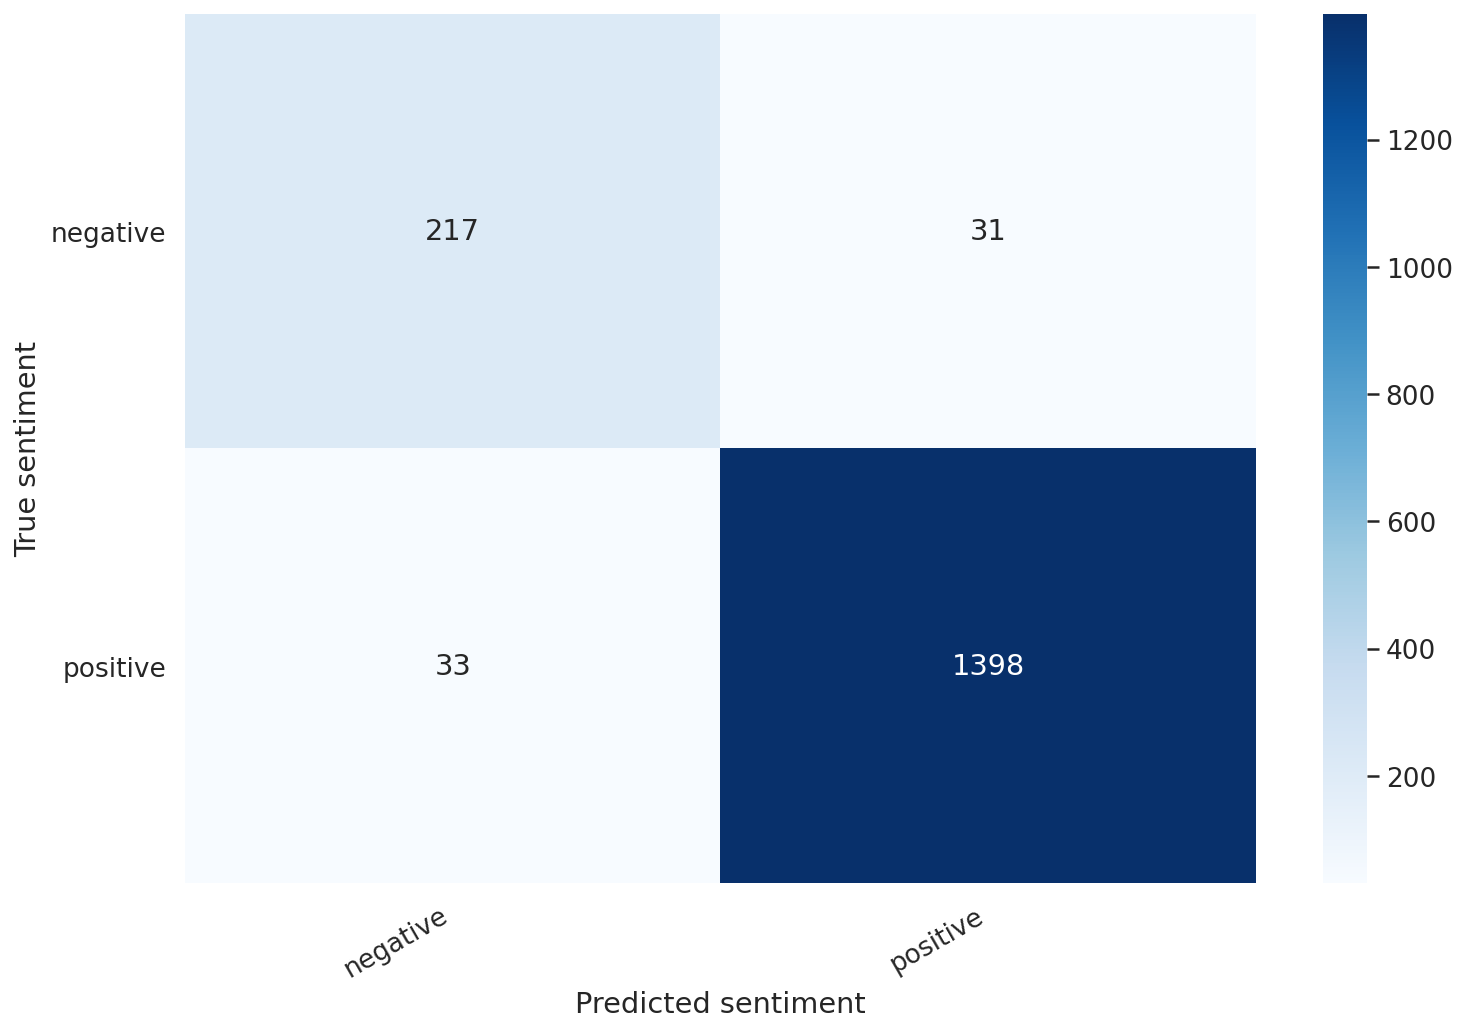

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

# Sentiment Analysis

### All Reviews

In [ ]:
df_sent_raw = pd.read_csv('Sentences_for_SA.csv')

In [ ]:
sentence = []
probability = []
sentiment = []

for i in range(len(df_sent_raw)):
  review_text = df_sent_raw.sentence[i]

  encoded_review = tokenizer.encode_plus(
      review_text,
      max_length=MAX_LEN,
      add_special_tokens=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True)
  
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)

  prob = format(torch.max(F.softmax(output, dim=1), dim=1)[0].item(), '.10f')

  x = str(review_text)
  y = str(class_names[prediction]) 
  z = str(prob)
  
  sentence.append(x)
  sentiment.append(y)
  probability.append(z)

df_sent = pd.DataFrame({'sentence': sentence,
                        'sentiment': sentiment, 
                        'probability': probability})
df_sent

,sentence,sentiment,probability
0,when ordering i was unsure if the holder would...,positive,0.9999954700
1,miss leading add it's not useful\nfor anything,negative,0.9999891520
2,very adaptable to all different location mounts.,positive,0.9999969006
3,i thought it was a speaker but it's just a lit...,negative,0.9999942780
4,"great product, great service.",positive,0.9999972582
...,...,...,...
225973,vifa didn't try to make it something a little ...,positive,0.9999946356
225974,try to put out big bloated low-end it doesn't ...,negative,0.8537041545
225975,and the build quality is excellent.,positive,0.9999971390
225976,i give it a four star rating rather than five ...,negative,0.9999949932


In [ ]:
df_sent.to_csv('SA_results_v7.csv')
files.download('SA_results_v7.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Thresholds

##### Not Three

In [ ]:
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

(1679, 3)

In [ ]:
df_vt = df_val.append(df_test)
df_vt.reset_index(drop=True, inplace=True)
df_vt.shape

(3357, 3)

In [ ]:
sentence = []
probability = []
sentiment = []
rating = []

for i in range(len(df_vt)):
  review_text = df_vt.content[i]

  encoded_review = tokenizer.encode_plus(
      review_text,
      max_length=MAX_LEN,
      add_special_tokens=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True)
  
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)

  prob = format(torch.max(F.softmax(output, dim=1), dim=1)[0].item(), '.10f')

  x = str(review_text)
  y = str(class_names[prediction]) 
  z = str(prob)
  r = df_vt.rating[i]
  
  sentence.append(x)
  sentiment.append(y)
  probability.append(z)
  rating.append(r)

df_thr_not3 = pd.DataFrame({'rating':rating,
                            'sentence': sentence,
                            'sentiment': sentiment, 
                            'probability': probability})

df_thr_not3.head()

,rating,sentence,sentiment,probability
0,5,Great little speaker thinking of getting in an...,positive,0.9999971390
1,5,great product for the price it rivals the jbl ...,positive,0.9999971390
2,5,Has great sound... including bass.Battery last...,positive,0.9999971390
3,5,I have many radios some have good sound but th...,positive,0.9999954700
4,5,Love it we use it on our hikes 😎,positive,0.9999970198


In [ ]:
df_thr_not3.probability = df_thr_not3.probability.astype(float)

[np.mean(df_thr_not3[df_thr_not3.rating == 1].probability),
 np.mean(df_thr_not3[df_thr_not3.rating == 2].probability),
 np.mean(df_thr_not3[df_thr_not3.rating == 4].probability),
 np.mean(df_thr_not3[df_thr_not3.rating == 5].probability)]

[0.9964243892373527, 0.995881008851409, 0.998715618413146, 0.999055822815841]

In [ ]:
df_thr_not3.to_csv('SA_v7_thr_!3star.csv')
files.download('SA_v7_thr_!3star.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Is Three

In [ ]:
df_raw_is3 = df_raw[df_raw.rating == 3]
df_raw_is3.reset_index(drop=True, inplace=True)
df_raw_is3.head()

,rating,content
0,3,Everything works fine but not up to my expecta...
1,3,"This speaker does it's job, and it's pretty in..."
2,3,If the volume is higher than 50% the speaker s...
3,3,Volume is not loud enough
4,3,"It's a decent size and produces a nice sound, ..."


In [ ]:
sentence = []
probability = []
sentiment = []
rating = []

for i in range(len(df_raw_is3)):
  review_text = df_raw_is3.content[i]

  encoded_review = tokenizer.encode_plus(
      review_text,
      max_length=MAX_LEN,
      add_special_tokens=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True)
  
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)

  prob = format(torch.max(F.softmax(output, dim=1), dim=1)[0].item(), '.10f')

  x = str(review_text)
  y = str(class_names[prediction]) 
  z = str(prob)
  r = df_raw_is3.rating[i]
  
  sentence.append(x)
  sentiment.append(y)
  probability.append(z)
  rating.append(r)

df_thr_is3 = pd.DataFrame({'rating':rating,
                            'sentence': sentence,
                            'sentiment': sentiment, 
                            'probability': probability})
df_thr_is3.head()

,rating,sentence,sentiment,probability
0,3,Everything works fine but not up to my expecta...,positive,0.9999959469
1,3,"This speaker does it's job, and it's pretty in...",positive,0.9999969006
2,3,If the volume is higher than 50% the speaker s...,negative,0.9999907017
3,3,Volume is not loud enough,negative,0.9997723699
4,3,"It's a decent size and produces a nice sound, ...",negative,0.9999570847


In [ ]:
np.mean(df_thr_is3.probability.astype(float))

0.9941179282697378

In [ ]:
df_thr_is3.to_csv('SA_v7_thr_3star.csv')
files.download('SA_v7_thr_3star.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Merge

In [ ]:
df_thr = df_thr_not3.append(df_thr_is3)
df_thr.reset_index(drop=True, inplace=True)
df_thr.head()

,rating,sentence,sentiment,probability
0,5,Great little speaker thinking of getting in an...,positive,0.999997
1,5,great product for the price it rivals the jbl ...,positive,0.999997
2,5,Has great sound... including bass.Battery last...,positive,0.999997
3,5,I have many radios some have good sound but th...,positive,0.999995
4,5,Love it we use it on our hikes 😎,positive,0.999997


In [ ]:
df_thr.to_csv('SA_v7_thr.csv')
files.download('SA_v7_thr.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
[df_thr[df_thr.rating == 5]['probability'].astype(float).mean(),
 df_thr[df_thr.rating == 4]['probability'].astype(float).mean(),
 df_thr[df_thr.rating == 3]['probability'].astype(float).mean(),
 df_thr[df_thr.rating == 2]['probability'].astype(float).mean(),
 df_thr[df_thr.rating == 1]['probability'].astype(float).mean()]

[0.999055822815841,
 0.998715618413146,
 0.9941179282697378,
 0.995881008851409,
 0.9964243892373527]

### Reference

This notebook refers to an online tutorial for test classification created by Venelin Valkov in the following link:

https://www.youtube.com/watch?v=8N-nM3QW7O0